# Setup

In [45]:
import os
import shutil
import csv

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# Dataset

In [29]:
def load_dataset(filename):
    texts = []
    sentiments = []
    with open(filename, 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=';')
        next(spamreader)
        for row in spamreader:
            texts.append(row[1])
            sentiments.append(int(row[3]))
    return texts, sentiments

In [30]:
train_text, train_sentiment = load_dataset('archive/TrainingDatasets/Train100.csv')
test_text, test_sentiment = load_dataset('archive/TestDatasets/Test.csv')

In [36]:
import nltk

train_text = [nltk.word_tokenize(text) for text in train_text]
vocab = set()
for text in train_text:
    vocab.update(text.lower())

vocab = list(vocab)
print('Vocab size:', len(vocab))

Vocab size: 142144


In [56]:
tok2idx = {tok:i+2 for i,tok in enumerate(vocab)}
tok2idx['<pad>'] = 0
tok2idx['<oov>'] = 1

In [43]:
max_seq_len = max(len(text) for text in train_text)
max_seq_len

178

In [94]:
def vec_sentence(text):
    vec = np.zeros(max_seq_len)
    for i in range(len(text)):
        if i >= max_seq_len:
            return vec
        token = text[i].lower()
        if token in tok2idx:
            vec[i] = tok2idx[token]
        else:
            vec[i] = 1
    return vec

In [60]:
vec_sentence(train_text[0])

array([ 63697.,  70046.,  87568., 138097.,  51753.,  75163.,  61443.,
       141203.,  74094.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,     

In [95]:
X_train = np.array([vec_sentence(text) for text in train_text])
Y_train = np.array(train_sentiment)
X_test = np.array([vec_sentence(text) for text in test_text])
Y_test = np.array(test_sentiment)

In [96]:
X_train

array([[ 63697.,  70046.,  87568., ...,      0.,      0.,      0.],
       [ 34349., 108569., 109118., ...,      0.,      0.,      0.],
       [100467.,  81089.,  31976., ...,      0.,      0.,      0.],
       ...,
       [ 99707.,  60282., 121234., ...,      0.,      0.,      0.],
       [ 34349., 102434.,  76099., ...,      0.,      0.,      0.],
       [ 83308.,  57722., 138097., ...,      0.,      0.,      0.]])

In [99]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

train_ds = train_ds.shuffle(len(train_ds)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(len(test_ds)).prefetch(tf.data.AUTOTUNE)

# Model

In [122]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tok2idx), 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=False)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

In [123]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          4548672   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 128)         37632     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128)               74496     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 4,669,121
Trainable params: 4,669,121
Non-trainable params: 0
_________________________________________________________________


In [126]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'], optimizer='Adam')

# Training

In [127]:
history = model.fit(train_ds, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 1668s 1s/step - loss: 0.0312 - accuracy: 0.9906
Epoch 2/5
1563/1563 [==============================] - 949s 607ms/step - loss: 0.0090 - accuracy: 0.9977
Epoch 3/5
1563/1563 [==============================] - 877s 561ms/step - loss: 0.0031 - accuracy: 0.9990
Epoch 4/5
1563/1563 [==============================] - 888s 568ms/step - loss: 0.0013 - accuracy: 0.9996
Epoch 5/5
1563/1563 [==============================] - 900s 576ms/step - loss: 8.9467e-04 - accuracy: 0.9997


# Evaluation

In [128]:
model.evaluate(test_ds)

1/1 [==============================] - 14s 14s/step - loss: 0.1715 - accuracy: 0.9676


[0.17150534689426422, 0.9675999879837036]

In [129]:
Y_pred = model.predict(X_test)

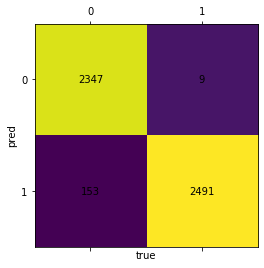

In [157]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, Y_pred > 0.5)

plt.matshow(cm)
plt.xlabel('true')
plt.ylabel('pred')
for i in range(2):
    for j in range(2):
        plt.text(i, j, cm[i,j], ha='center', va='center')
plt.show()